## import packages

In [1]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
import imageio
from IPython.display import HTML


In [2]:
import pytoolsAL as ptAL

pytoolsAL: Modules missing.  Not loading image.  Message: cannot import name 'geometry' from 'skimage._shared' (c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\skimage\_shared\__init__.py)
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/user_guide/install.html
pytoolsAL: Modules missing.  Not loading neuropixels.  Message: No module named 'slidingRP'
pytoolsAL: Modules missing.  Not loading plotting.  Message: No module named 'pandas'


In [3]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [4]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

## brain func

In [4]:
def brain(data,galvoX=0,galvoY=0,power=2,frame=100,n_samples=300,start=0,end=1,X=150,Y=350):
    '''
    image of the brain
    can change where you stim (galvoX, galvoY),
        power you stimulate with, frame you take as peak,
        and samples in trial
        frame which you take your img from, just a single one
    '''
    pows = np.argwhere(data.laserPowers==power).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY)
    galvoXTrs=np.argwhere(data.galvoX==galvoX)
    loc=np.intersect1d(galvoXTrs,galvoYTrs)
    theseTrs=np.intersect1d(loc,pows)

    trial_time_all = [np.linspace(i-start, i+end, n_samples)*1000 for i in theseTrs]
    trial_activity_all = data.tToWf(trial_time_all)
    trial_activity_all = np.mean(trial_activity_all, axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
    dwf = np.array(dwf)
    
    spatial = data.svdSpatFull.reshape(560*560, -1)
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1)
    
    plt.imshow(videoAvg[:,:,frame], cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
    plt.scatter(X,Y,color='orange',s=15)

## Power:Inactivation figs

### import

In [48]:
dataOp312_AB = wfOpto(Path(r'Y:\Subjects\AB_0026\2024-03-12\1'))

In [59]:
dataOp425_AB = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [61]:
dataOp621_AB = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-21\1'))

In [62]:
dataOp729_AB = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-07-29\1'))

In [69]:
dataOp729_AB_exp = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-07-29\3'))

In [6]:
dataOp628_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-28\3'))

In [44]:
dataOp718_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-18\1'))

In [46]:
dataOp712_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-12\1'))

In [48]:
dataOp709_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-09\1'))

In [50]:
dataOp622_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))

In [5]:
dataOp809_AL33= wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-09\1'))

### fig funcs

#### with deconv and ROI

In [25]:
def powerDep3Pow(ax,data,mouse,date,galvoX,galvoY,y,x,width=15,n_samples=650,pows=[0.2,1.7,3],ylim=[-40,40]):
    colors=['deepskyblue','dodgerblue','mediumblue']
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    # x=240
    #changes per mouse
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y,x), (data.py, data.px))
    for iP, power in enumerate(pows):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
        dwf = np.array(dwf)
        mov = data.svdSpat @ dwf
        mov = mov.reshape(560,560,-1)
        videoROI = mov[(y-width):(y+width), (x-width):(x+width)] # ROI vid with average activity
        avgOverRoi=np.mean(videoROI,axis=(0,1))
        pxPowers.append(avgOverRoi)

    for c,iP in enumerate(pxPowers):
        plt.plot(timestamps, iP,linewidth=2,color=colors[c])
        plt.fill_between(timestamps, \
                iP-scipy.stats.sem(iP,axis=0),\
                iP+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
        
    plt.legend(['0.07 mW', '0.63 mW', '1.1 mW'], loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)')
    plt.ylabel('Brain Activity df')
    plt.title(f'Inactivation 3 Powers mouse {mouse} {date}')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)

In [26]:
def powerDepAllPow(ax,data,mouse,date,galvoX,galvoY,y,x,width=15,n_samples=650):
    powers = np.unique(data.laserPowers)
    colors=plt.cm.Blues(np.linspace(0,1,powers.shape[0]))
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #this depends on mouse (and maybe day) !!!!!
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
        dwf = np.array(dwf)
        mov = data.svdSpat @ dwf
        mov = mov.reshape(560,560,-1)
        videoROI = mov[(y-width):(y+width), (x-width):(x+width)] # ROI vid with average activity
        avgOverRoi=np.mean(videoROI,axis=(0,1))
        pxPowers.append(avgOverRoi)


    for i,iP in enumerate(pxPowers):
        plt.plot(timestamps, iP,color=colors[i])
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('time (ms)')
    plt.title('Inactivation All Powers')

In [29]:
def powerQuant(ax,data,y,x,galvoX,galvoY,width=15,n_samples=650):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #changes per mouse!!
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
        dwf = np.array(dwf)
        mov = data.svdSpat @ dwf
        mov = mov.reshape(560,560,-1)
        videoROI = mov[(y-width):(y+width), (x-width):(x+width)] # ROI vid with average activity
        avgOverRoi=np.mean(videoROI,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean)
    plt.xlabel("Laser powers (mW)")
    plt.title("Inactivation at Peak (90 ms)")

#### with df/f and ROI

In [7]:
def powerDep3Pow(ax,data,mouse,date,galvoX,galvoY,y,x,width=15,n_samples=650,pows=[0.2,1.7,3]):
    colors=['deepskyblue','dodgerblue','mediumblue']
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    for iP, power in enumerate(pows):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    for c,iP in enumerate(pxPowers):
        plt.plot(timestamps, iP,linewidth=2,color=colors[c])
        plt.fill_between(timestamps, \
                iP-scipy.stats.sem(iP,axis=0),\
                iP+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
        
    plt.legend(['0.07 mW', '0.63 mW', '1.1 mW'], loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)',fontsize=10)
    plt.ylabel('Brain Activity df/f',fontsize=10)
    plt.title(f'Inactivation 3 Powers mouse {mouse} {date}',fontsize=15)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')


In [8]:
def powerDepAllPow(ax,data,mouse,date,galvoX,galvoY,y,x,width=15,n_samples=650):
    powers = np.unique(data.laserPowers)
    colors=plt.cm.Blues(np.linspace(0,1,powers.shape[0]))
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #this depends on mouse (and maybe day) !!!!!
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    for i,iP in enumerate(pxPowers):
        plt.plot(timestamps, iP,color=colors[i])
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('Time (ms)',fontsize=10)
    plt.title('Inactivation All Powers',fontsize=15)


In [9]:
def powerQuant(ax,data,y,x,galvoX,galvoY,width=15,n_samples=650):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #changes per mouse!!
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')

    time90 = pixelInterp(90)

    # timeMean = np.mean(time90, axis=0)
    plt.plot(powers,time90,'-o',c='k',lw=2)
    plt.errorbar(powers,time90,yerr=.01,c='k')
    plt.scatter(powers,time90)
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title('Peak inactivation',fontsize=15)

### panels, and specify day

In [24]:
np.unique(dataOp628_AB32.laserPowers)

array([0.1, 0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2])

In [52]:
np.unique(dataOp312_AB.laserPowers)

array([0.2, 0.5, 1. , 1.5, 2. , 2.5, 3.2])

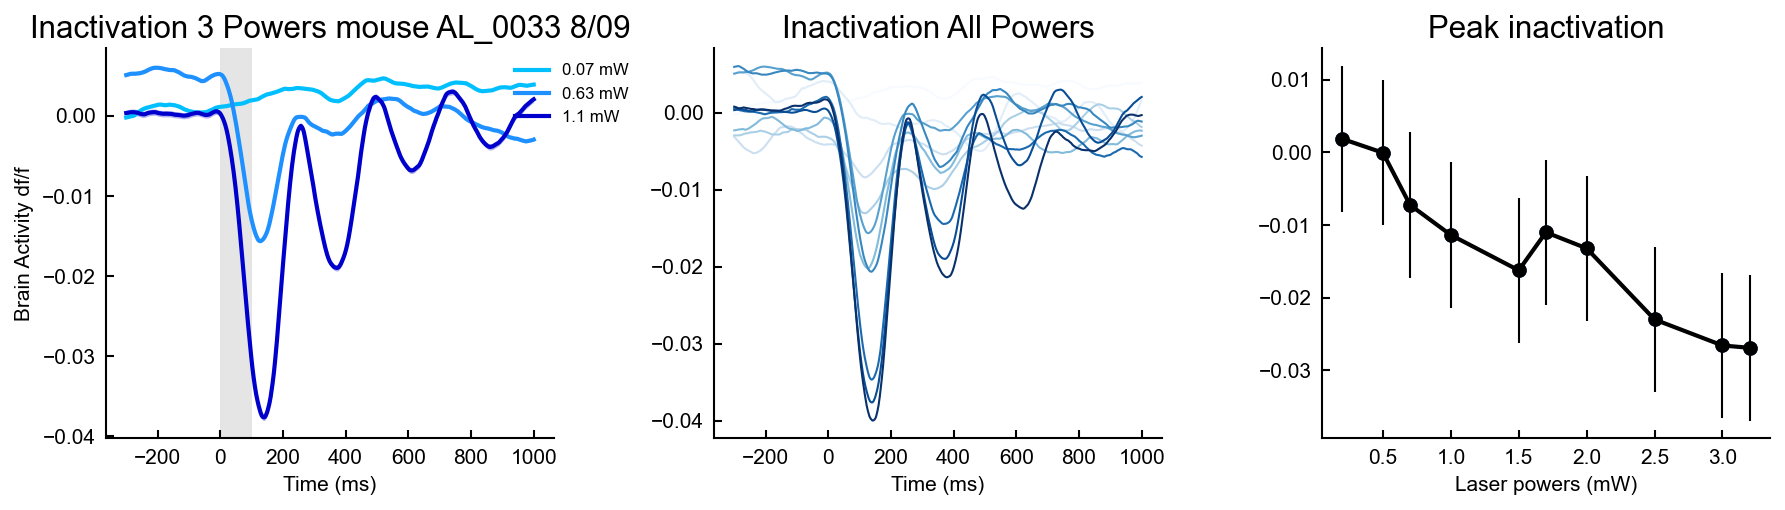

In [10]:
data=dataOp809_AL33
mouse="AL_0033"
date="8/09"
y=350
x=170
galvoX=0
galvoY=3
powers=[.2,1.7,3]
ylim=[-0.06,0.04]

f = plt.figure(figsize=(12, 3.5))
gs = mpl.gridspec.GridSpec(1, 3)
ax = plt.subplot(gs[0])
powerDep3Pow(ax,data=data,galvoX=galvoX,galvoY=galvoY,y=y,x=x,pows=powers,mouse=mouse,date=date,n_samples=650)

ax = plt.subplot(gs[1])
powerDepAllPow(ax,data=data,galvoX=galvoX,galvoY=galvoY,y=y,x=x,mouse=mouse,date=date)

ax = plt.subplot(gs[2])
powerQuant(ax,data=data,galvoX=galvoX,galvoY=galvoY,y=y,x=x)

f.tight_layout()

In [ ]:
f.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}_calib')

### overlaying multiple days/preparations

In [65]:
def powerQuantReturn(data,y,x,galvoY,galvoX,width=15,n_samples=650):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #changes per mouse!!
    galvoXtrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYtrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXtrs,galvoYtrs)

    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')

    time90 = pixelInterp(90)

    return(time90)

In [66]:
quant312=powerQuantReturn(data=dataOp312_AB,y=350,x=170,galvoX=0,galvoY=2.5)
quant425=powerQuantReturn(data=dataOp425_AB,y=350,x=170,galvoX=0,galvoY=3.3)
quant612=powerQuantReturn(data=dataOp621_AB,y=350,x=170,galvoX=0,galvoY=4)
quant729=powerQuantReturn(data=dataOp729_AB,y=350,x=170,galvoX=0,galvoY=4)
days=[quant312,quant425,quant612,quant729]

accross days

In [61]:
powers=np.unique(dataOp718_AL33.laserPowers)
for day in days:
    print(powers[0:day.shape[0]])

[0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]


In [63]:
np.unique(dataOp709_AL33.laserPowers)

array([0.1, 0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2])

Text(0.5, 1.0, 'Inactivation at Peak Across Days mouse AB32')

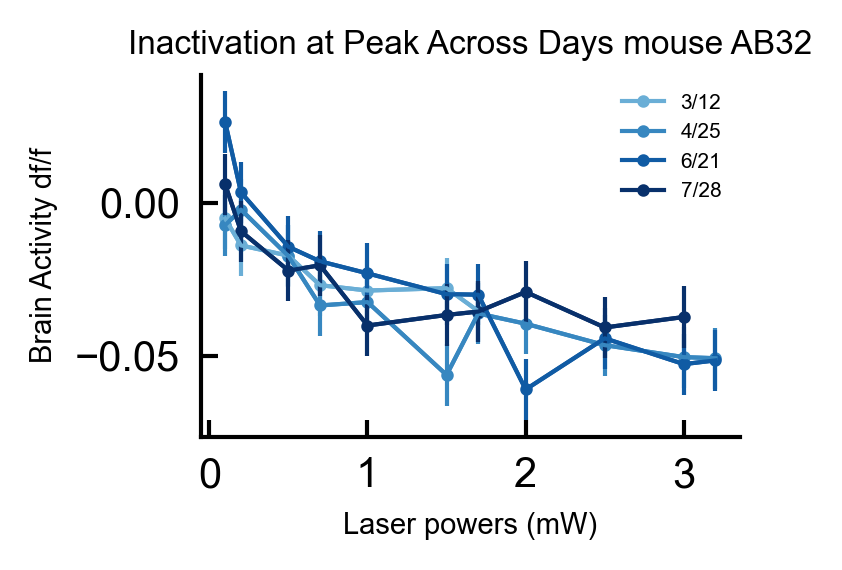

In [68]:
mouse='AB32'
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers=np.unique(dataOp425_AB.laserPowers)
colors=plt.cm.Blues(np.linspace(0.5,1,4))
labels=['3/12','4/25', '6/21','7/28']
for i,day in enumerate(days):
    plt.plot(powers[0:day.shape[0]],day,'-o',c=colors[i],lw=1,markersize=2)

    plt.errorbar(powers[0:day.shape[0]],day,yerr=0.01,c=colors[i],label='_nolegend_')

    plt.scatter(powers[0:day.shape[0]],day,label='_nolegend_',s=.5)

plt.legend(labels,loc='upper right',fontsize=5)
plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel('Brain Activity df/f',fontsize=7)
plt.title(f"Inactivation at Peak Across Days mouse {mouse}",fontsize=8)

across preps

In [19]:
def powerQuantReturn2(data,y,x):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    return(np.mean(time90, axis=1))

In [46]:
quant816_ZYE=powerQuantReturn2(data=dataOp816_ZYE,y=300,x=200)
quant822_ZYE=powerQuantReturn2(data=dataOp822_ZYE,y=300,x=200)
quant621_AL=powerQuantReturn2(data=dataOp621_AL,y=420,x=120)
quant622_AL=powerQuantReturn2(data=dataOp622_AL,y=420,x=120)
mice=[quant816_ZYE,quant822_ZYE,quant425,quant621_AL,quant622_AL]

Text(0.5, 1.0, 'Inactivation at Peak Across Preps')

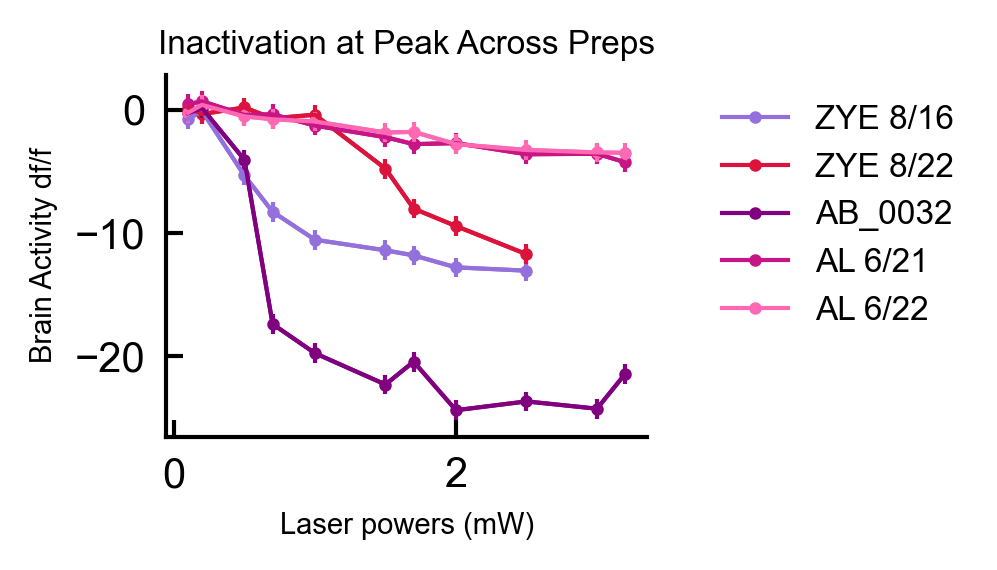

In [47]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers=np.unique(dataOp425.laserPowers)
colors=['mediumpurple', 'crimson', 'purple','mediumvioletred','hotpink']
labels=['ZYE 8/16','ZYE 8/22','AB_0032', "AL 6/21","AL 6/22"]
for i,mouse in enumerate(mice):
    plt.plot(powers[0:len(mouse)],mouse,'-o',c=colors[i],lw=1,markersize=2)

    plt.errorbar(powers[0:len(mouse)],mouse,yerr=.8,c=colors[i],label='_nolegend_')

    plt.scatter(powers[0:len(mouse)],mouse,label='_nolegend_',c=colors[i],s=.5)

plt.legend(labels,loc='upper right',bbox_to_anchor=(1.7,1))
plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel("Brain Activity df/f",fontsize=7)
plt.title("Inactivation at Peak Across Preps",fontsize=8)

## Stim Length figs

### import

In [29]:
dataOp729=wfOpto(Path(r'Y:\Subjects\AL_0034\2024-07-29\1'))

In [71]:
dataOp729_exp=wfOpto(Path(r'Y:\Subjects\AL_0034\2024-07-29\3'))

In [42]:
dataSt627_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-27\1'))

In [5]:
dataSt725_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-25\1'))

In [22]:
dataSt719_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-07-19\1'))

In [34]:
dataSt627_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-27\1'))

In [42]:
dataSt627_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-27\1'))

In [46]:
dataSt625_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-25\1'))

KeyboardInterrupt: 

In [11]:
dataSt_nosine_AB = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-05-21\1'))

### fig funcs

#### with deconv

In [14]:
dataSt725_AL33.laserPowers.size

660

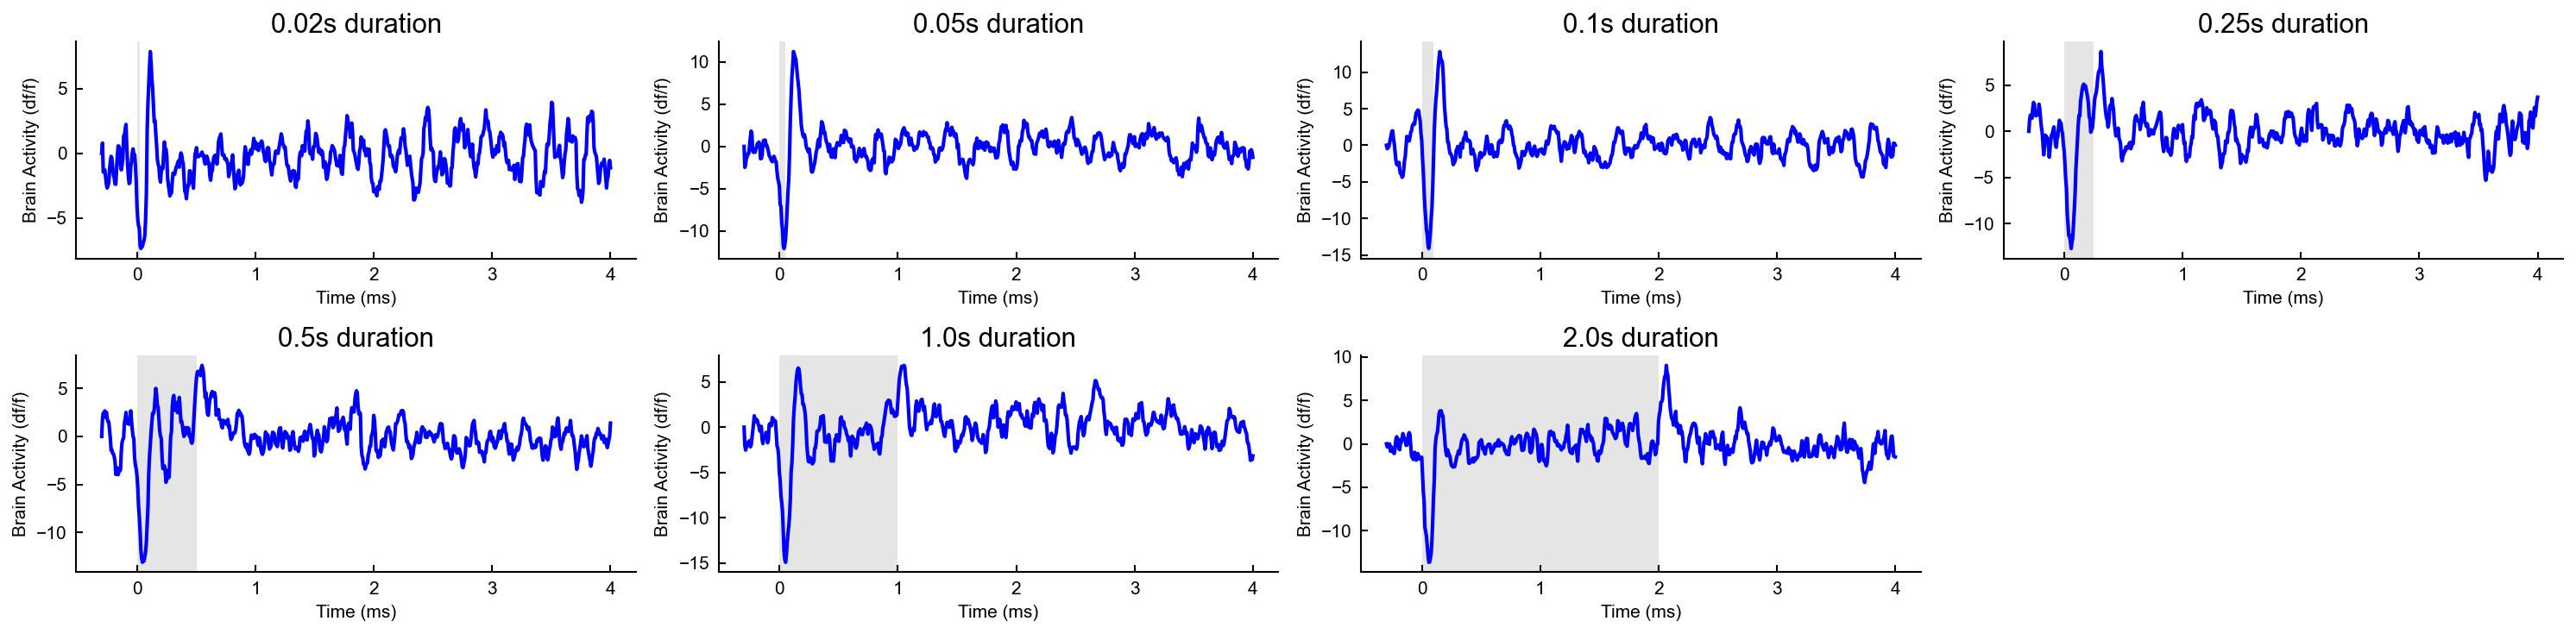

In [18]:
data=dataSt627_AB32
mouse='AB32'
date='7/25'
power=1.7
y=350
x=300
n_samples=650
width=15
lens = np.unique(data.pulseLengths)
colors=plt.cm.Blues(np.linspace(0,1,lens.size))
pxLen = [] 
timestamps = np.linspace(-0.3, 4, n_samples)
pws=np.argwhere(data.laserPowers==1.5).ravel()

pxPowers=[]
for iP, len in enumerate(lens):
    lenTrs = np.argwhere(data.pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    wf = np.mean(data.tToWFManual(trs),axis=0)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
    dwf = np.array(dwf)
    mov = data.svdSpat @ dwf
    mov = mov.reshape(560,560,-1)
    videoROI = mov[(y-width):(y+width), (x-width):(x+width)] # ROI vid with average activity
    avgOverRoi=np.mean(videoROI,axis=(0,1))
    pxPowers.append(avgOverRoi)

pxPowers = np.array(pxPowers)

f = plt.figure(figsize=(20, 5))
gs = mpl.gridspec.GridSpec(2,4)

for i,iL in enumerate(pxPowers):
    ax = plt.subplot(gs[i])
    ax.plot(timestamps,iL,color='blue',lw=2)
    ax.axvspan(0,lens[i],color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.title(f'{lens[i]}s duration',fontsize=15)
    plt.xlabel('Time (ms)')
    plt.ylabel('Brain Activity (df/f)')

#### with df/f

c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


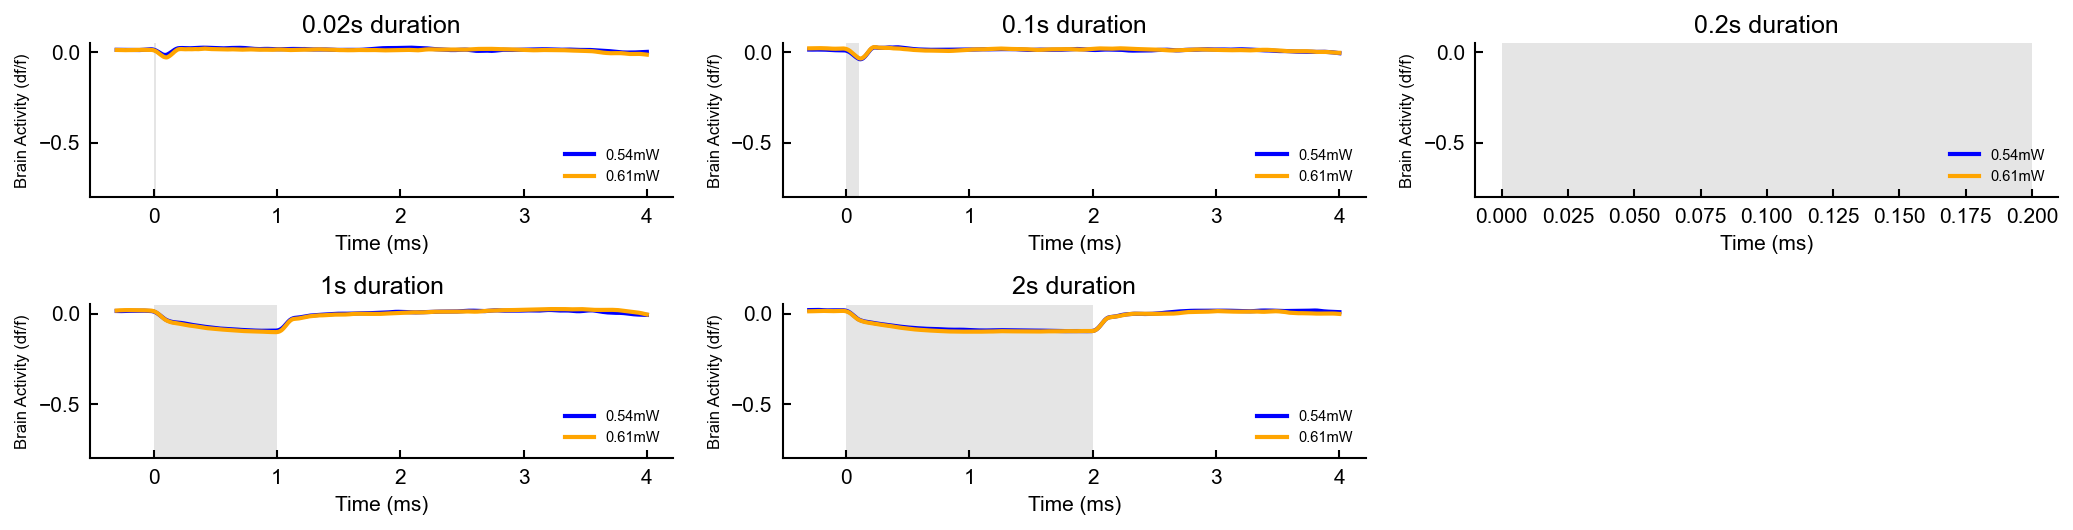

In [72]:
data=dataOp729_exp
mouse='AL34'
date='7/29'
y=400
x=170
n_samples=650
width=15
# lens = np.unique(data.pulseLengths)
lens=[0.02,0.1,0.2,1,2]
powers = [1.5,1.7]
colors=plt.cm.Blues(np.linspace(0,1,5))
pxLen = []
timestamps = np.linspace(-0.3, 4, n_samples)

pxPowers = np.zeros((2,7,n_samples),dtype=float)
pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
for iP,power in enumerate(powers):
    pws=np.argwhere(data.laserPowers==power).ravel()
    for iL, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers[iP,iL,:] = avgOverRoi

f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(3,3)
for iL,len in enumerate(lens):
    ax = plt.subplot(gs[iL])
    ax.plot(timestamps,pxPowers[0,iL],color='blue',lw=2,label='0.54mW')
    ax.plot(timestamps,pxPowers[1,iL],color='orange',lw=2,label='0.61mW')
    ax.axvspan(0,len,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.legend(loc='lower right',fontsize=7)
    plt.title(f'{len}s duration',fontsize=12)
    plt.xlabel('Time (ms)',fontsize=10)
    plt.ylabel('Brain Activity (df/f)',fontsize=8)
    plt.ylim([-0.8,0.05])
f.tight_layout()

Text(0.5, 1.0, 'Time brain remains inactivated')

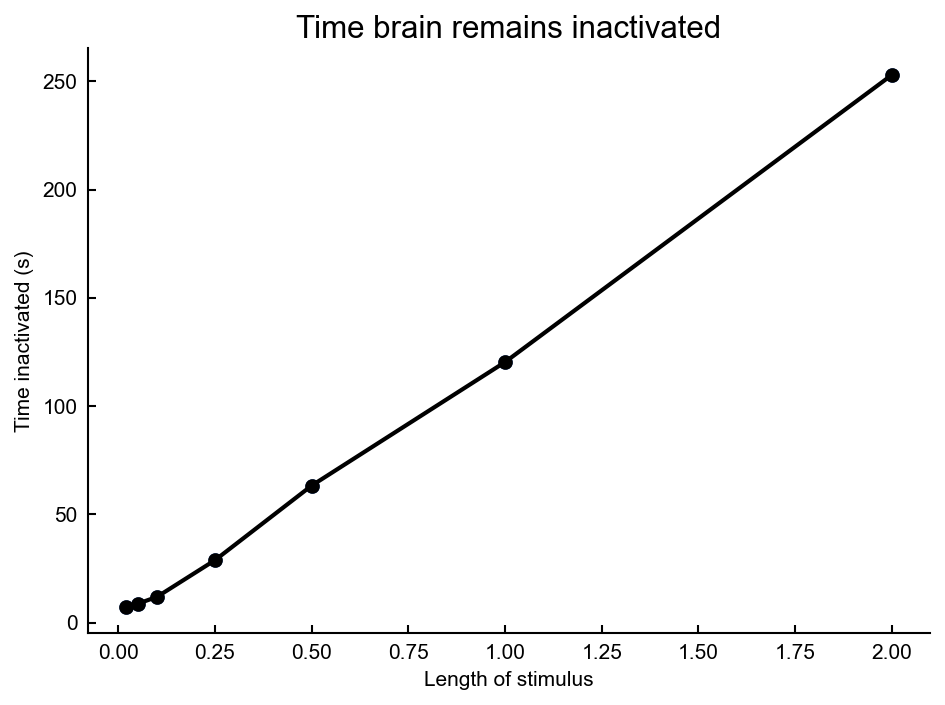

In [73]:
data=dataOp729_exp
mouse='AL34'
date='7/29'
power=1.5
y=400
x=170
n_samples=650
width=15
lens = np.unique(data.pulseLengths)
colors=plt.cm.Blues(np.linspace(0,1,lens.size))
pxLen = []
timestamps = np.linspace(-0.3, 4, n_samples)
pws=np.argwhere(data.laserPowers==power)

time = []
pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
for iP, len in enumerate(lens):
    lenTrs = np.argwhere(data.pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    wf = np.mean(data.tToWFManual(trs),axis=0)
    mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
    mov = mov.reshape(560,560,-1)
    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
    mov_mean_dff = videoROI/avg
    peak = np.min(mov_mean_dff)
    halfpeak=peak/2
    tf = [i<halfpeak for i in mov_mean_dff]
    deac = mov_mean_dff[tf]
    time.append(deac.shape[0]*(1/1000))

plt.plot(lens,time,'-o',c='k',lw=2)
plt.errorbar(lens,time,yerr=.01,c='k')
plt.scatter(lens,time)
plt.xlabel("Length of stimulus",fontsize=10)
plt.ylabel("Time inactivated (s)",fontsize=10)
plt.title('Time brain remains inactivated',fontsize=15)

### panels (not using currently)

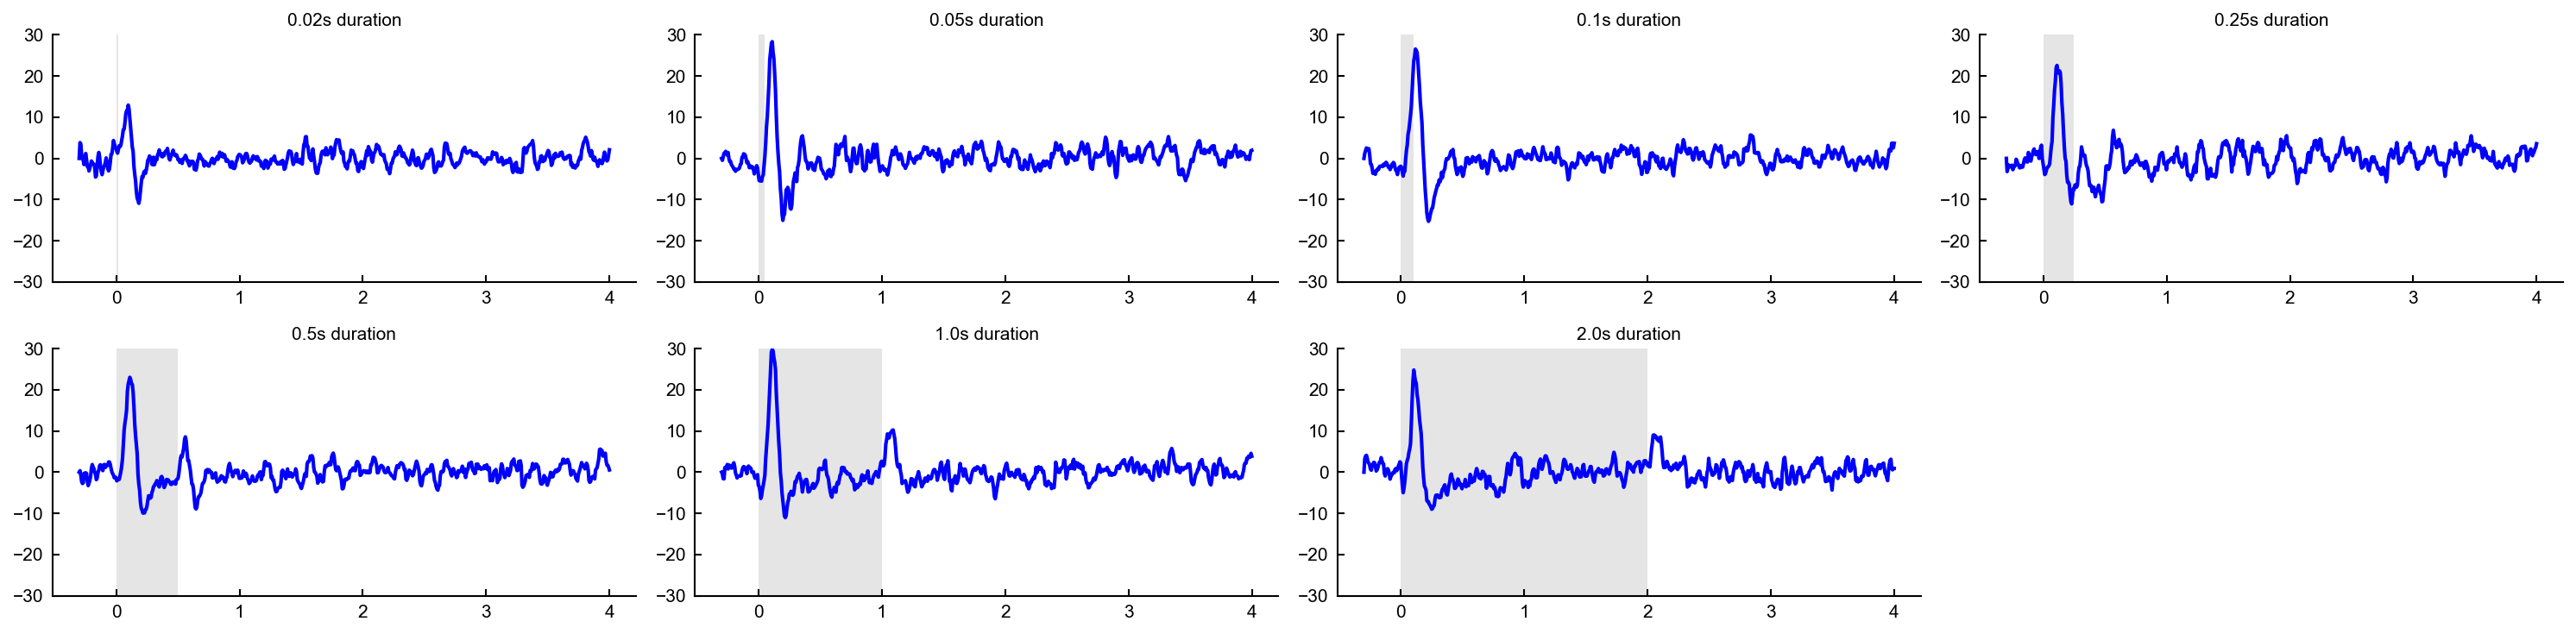

In [16]:
# f = plt.figure(figsize=(14, 5))
# gs = mpl.gridspec.GridSpec(2,3)
# pow=.7
# lenList=np.array([0.01,0.1,1,3])

# ax = plt.subplot(gs[0])
stimDepPow(ax,data=data)

# ax = plt.subplot(gs[1])
# stimDepPowMod(ax,ylim,data,pow,lenList)

# f.tight_layout()

In [ ]:
f.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}')

## Contralat. Responses

### import

### panels and pick a day

In [ ]:
day=
mouse=
date=

In [71]:
#presents
power_pick = 2
n_samples=650
timestamps=np.linspace(-.3,1,n_samples)*1000
power = np.argwhere(dataOp622_AL.laserPowers==power_pick).ravel() 
galvoX=np.argwhere(dataOp622_AL.galvoX==2).ravel() #change for loc stim
galvoY=np.argwhere(dataOp622_AL.galvoY==3).ravel() #change for loc stim


#all the pixels we might need
pixel_RightPost=np.ravel_multi_index((390,400),(dataOp622_AL.py, dataOp622_AL.px))
pixel_LeftPost = np.ravel_multi_index((400,200),(dataOp622_AL.py,dataOp622_AL.px))
pixel_LeftAnt=np.ravel_multi_index((120,190),(dataOp622_AL.py, dataOp622_AL.px))
pixel_RightAnt=np.ravel_multi_index((120,310),(dataOp622_AL.py, dataOp622_AL.px))

#find trials
px = np.intersect1d(galvoY,galvoX)
theseTrs=np.intersect1d(px,power)
onTimes=dataOp622_AL.laserOn[theseTrs]
trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
trs=np.squeeze(np.array(trs))

thisPowerLP=[]
thisPowerRP=[]
thisPowerLA=[]
thisPowerRA=[]
#finding movies for those trials in those locations
for iT, tr in enumerate(trs):
    wf=dataOp622_AL.tToWf(tr)
    dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
    dwf=np.array(dwf)

    #find traces for each pixel

    #posterior
    movRightP=dataOp622_AL.svdSpat[pixel_RightPost]@dwf
    thisPowerRP.append(movRightP)
    movLeftP=dataOp622_AL.svdSpat[pixel_LeftPost]@dwf
    thisPowerLP.append(movLeftP)

    #anterior
    movRightA=dataOp622_AL.svdSpat[pixel_RightAnt]@dwf
    thisPowerRA.append(movRightA)
    movLeftA=dataOp622_AL.svdSpat[pixel_LeftAnt]@dwf
    thisPowerLA.append(movLeftA)

thisPowerLP=np.array(thisPowerLP)
thisPowerRP=np.array(thisPowerRP)
thisPowerLA=np.array(thisPowerLA)
thisPowerRA=np.array(thisPowerRA)

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_11712\1381582743.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')


(-15.0, 15.0)

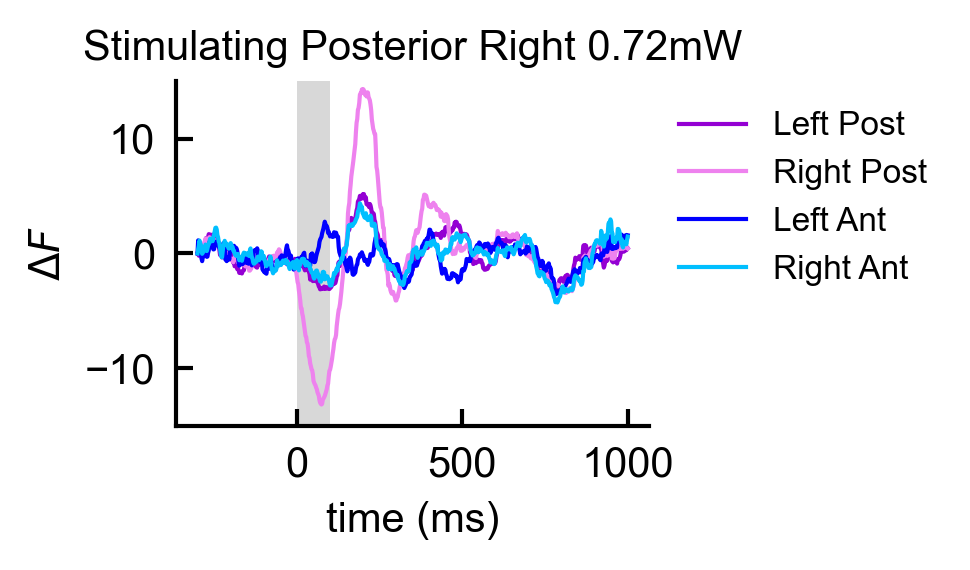

In [73]:
#plotting those trials and locations

f = plt.figure(figsize=(5/1.5, 3/1.5), dpi=300)
ax = plt.gca()

plt.plot(timestamps,np.mean(thisPowerLP,axis=0),color='darkviolet',label='Left Post')
plt.plot(timestamps,np.mean(thisPowerRP,axis=0),color='violet',label='Right Post')
plt.plot(timestamps,np.mean(thisPowerLA,axis=0),color='blue',label='Left Ant')
plt.plot(timestamps,np.mean(thisPowerRA,axis=0),color='deepskyblue',label='Right Ant')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.title(f'Stimulating Posterior Right {power_pick/2.7778:.2f}mW')
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$')
plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
plt.ylim([-15,15])

In [ ]:
f.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}')

### make a gif

In [ ]:
def makeVideo(data,galvoX=0,galvoY=3.3,power=1,n_samples=300):
    power = np.argwhere(data.laserPowers==power).ravel() 
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel() #change for loc stim
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel() #change for loc stim

    #find trials
    px = np.intersect1d(galvoYTrs,galvoXTrs)
    theseTrs=np.intersect1d(px,power)
    allVideos=[]

    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-0.1+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    wf = np.mean(data.tToWf(trs), axis=0)

    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data.svdSpat @ dwf
    allVideos = mov.reshape(data.px, data.py, -1)
    allVideos=np.array(allVideos)
    return allVideos


In [36]:
dataOp425.galvoX

array([ 3.3, -0. , -0. , ...,  3.3,  3.3,  3.3])

In [85]:
#checking pixel loc
allVideosOneFrame=np.mean(allVideosMean,axis=2)
#show where the pixels im chosing are 

plt.imshow(allVideosOneFrame,cmap='bwr')
#add all those pixels im tracking
plt.scatter(420,400,color='violet')
plt.scatter(120,420,color='darkviolet')
plt.scatter(200,120,color='blue')
plt.scatter(320,120,color='skyblue')

In [51]:
n_samples=300
vid425=makeVideo(data=dataOp425)

In [ ]:
n_samples=300
vid622=makeVideo(data=dataOp622_AL,galvoX=0,galvoY=3,power=3)

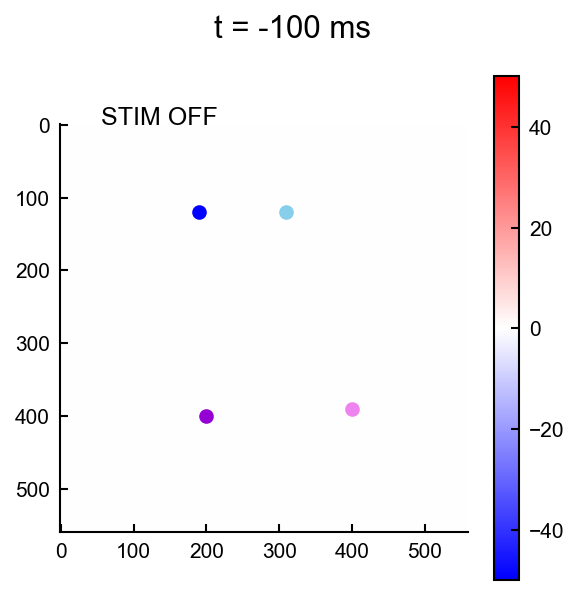

In [75]:
#find when the stim is on
f=plt.figure(figsize=(4, 4))

#make sure n_samples and timestamps are consistent between this code and the img making code - especially when youre making the trials for the images
n_samples=300
timestamps=np.linspace(-.1,1,n_samples)*1000
stimOn = np.intersect1d(np.argwhere(timestamps > 0).ravel(), np.argwhere(timestamps < 100).ravel())
ax=plt.subplot()
clim=np.percentile(vid622,(2,99.9)) 
img = plt.imshow(vid622[:,:,0],cmap='bwr',clim=np.r_[-1, 1]*50)
plt.colorbar()
plt.scatter(400,400,color='violet') #right post
plt.scatter(120,420,color='darkviolet') #left post
plt.scatter(220,120,color='blue') #left ant
plt.scatter(320,120,color='skyblue') #right ant
stext = plt.text(0.1, 0.999, '', fontsize='large', transform=ax.transAxes, zorder=20)

#set up the frames to loop through for the animation
def animate(i):
    img.set_array(vid622[:,:,i])
    f.suptitle(f't = {timestamps[i]:.0f} ms',size=15)
    if np.isin(i, stimOn):
        stext.set_text('STIM ON')
        stext.set_color('red')
    else:
        stext.set_text('STIM OFF')
        stext.set_color('k')

anim = mpl.animation.FuncAnimation(f, animate, frames=n_samples-1, cache_frame_data=False, interval=1)

In [76]:
savepath = 'C:/Users/nadia/Downloads/gif/425_LA.gif'

writergif=mpl.animation.PillowWriter(fps=60)
anim.save(savepath,writer=writergif)

## Visresp figs

### import

In [4]:
dataVis809=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-09\1')) # 2 locations. (1,0) and (4,0)

In [14]:
dataVis814=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-14\1')) # 2 locations. (1,0) and (4,0), more powers

In [15]:
dataVis815=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-15\1')) # 2 locations. (1,0) and (4,0), diff higher powers

In [68]:
dataVis823=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-23\3')) #3 locations across hemi

In [69]:
dataVis824=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-24\1')) #3 locations across hemi

In [ ]:
dataVis825=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-25\2')) #3 locations across hemi

In [126]:
serverPath = Path(r'Y:\Subjects\ZYE_0077\2024-07-22\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
# svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
# svdSpatFull = svdSpat[:,:,:500]

# meanImage = np.load(serverPath / 'blue/meanImage.npy')
# laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
# laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
# laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
# galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
# galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
# px, py, ncomps = svdSpatFull.shape

# self.svdSpat = self.svdSpatFull.reshape(self.px*self.py, self.ncomps)
tToWf = scipy.interpolate.interp1d(frameTimes, svdTemp, axis=0, fill_value='extrapolate')
# spatial = svdSpatFull.reshape(560*560,-1)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [127]:
len(frameTimes)

112412

In [128]:
len(svdTemp)

111777

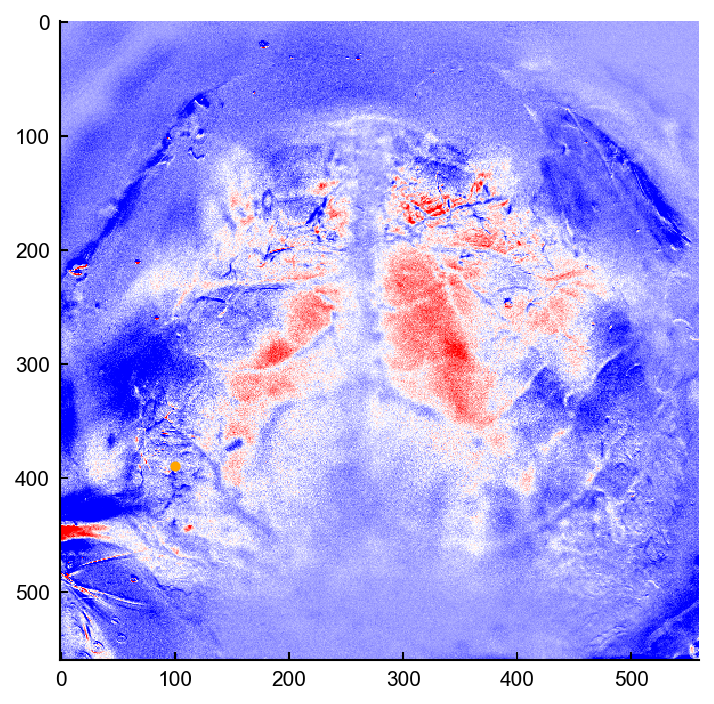

In [25]:
brain(dataVis809,galvoX=1,galvoY=0,power=0.7,frame=120,n_samples=650,start=.3,end=1,X=100,Y=390)

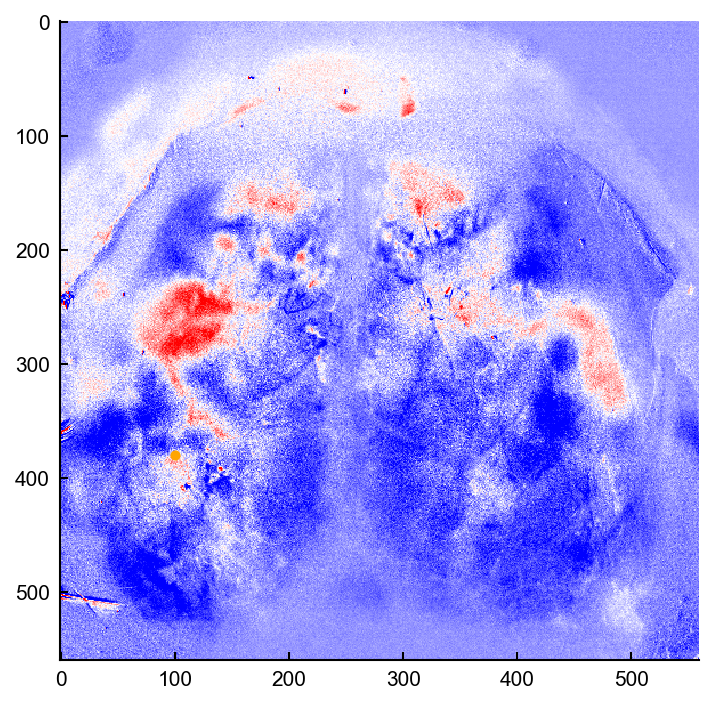

In [22]:
brain(dataVis814,galvoX=1,galvoY=0,power=3,frame=100,n_samples=300,start=.3,end=1,X=100,Y=380)

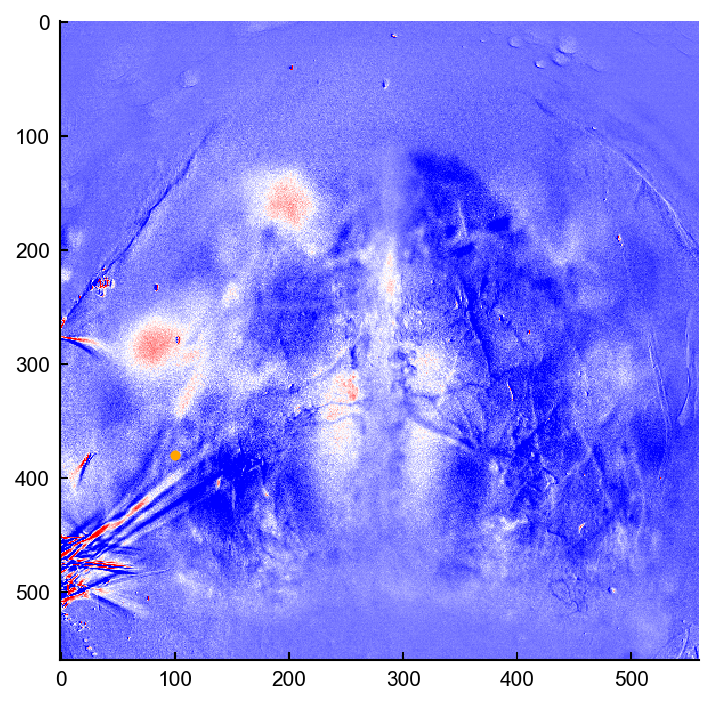

In [23]:
brain(dataVis815,galvoX=1,galvoY=0,power=5,frame=50,n_samples=300,start=-.3,end=1,X=100,Y=380)

### funcs and pick a day

In [ ]:
data=dataVis722
mouse='ZYE_0077'
day='07-22-2024'

In [58]:
def visRespAll(ax,data,galvoX=0,galvoY=0,x=120,y=380,n_samples=300):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #this depends on mouse (and maybe day) !!!!!
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for iP in pxPowers:
            plt.plot(timestamps, np.mean(iP, axis=0),color='k')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
        plt.xlabel('time (ms)')
        plt.title(f'Inactivation All Powers n={len(trs)}trs')
        plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')

In [28]:
def visRespQuant(ax,data,galvoX=0,galvoY=0,x=100,y=390,n_samples=300,time=90):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(time)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean)
    plt.xlabel("Laser powers (mW)")
    plt.title(f'Inactivation at Peak ({time} ms) n={len(trs)}trs')

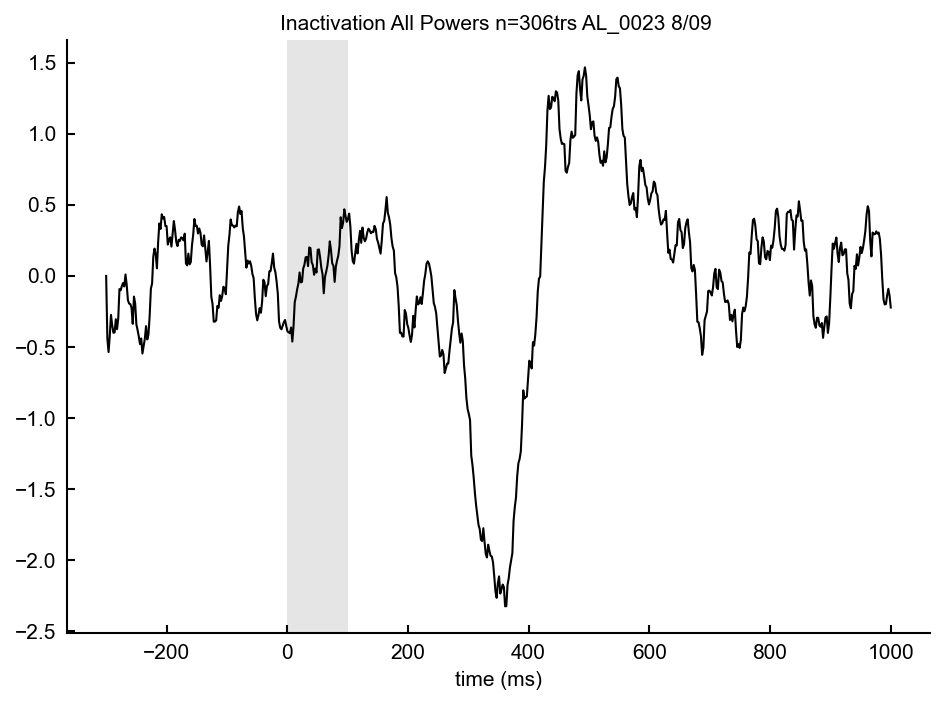

In [40]:
data=dataVis809;galvoX=1;galvoY=0;x=100;y=410;time=100;n_samples=650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

#this depends on mouse (and maybe day) !!!!!
galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
pw=np.argwhere(data.laserPowers==.7).ravel()
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(pw,loc)
pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))

theseTrs=np.intersect1d(pwTrs,loc)
onTimes = data.laserOn[theseTrs]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

thisPower = []
for iT, tr in enumerate(trs):
    wf = data.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data.svdSpat[pixel_ix] @ dwf
    thisPower.append(mov)
thisPower = np.array(thisPower)

plt.plot(timestamps, np.mean(thisPower, axis=0),color='k')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.xlabel('time (ms)')
plt.title(f'Inactivation All Powers n={len(trs)}trs AL_0023 8/09 ')
plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')

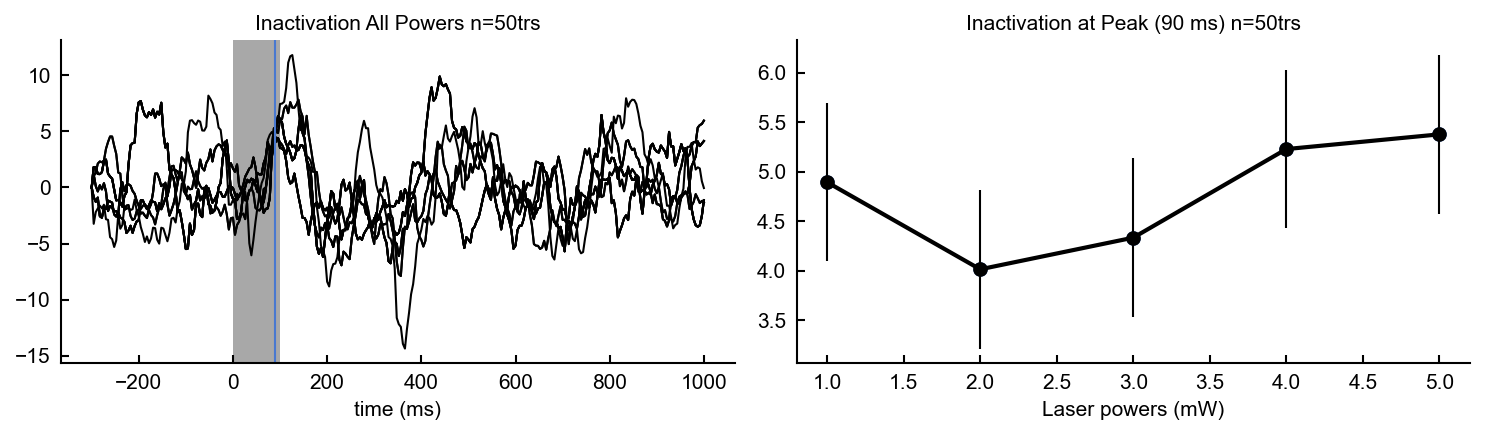

In [63]:
f = plt.figure(figsize=(10,3))
gs=mpl.gridspec.GridSpec(1,2)

time=90

ax = plt.subplot(gs[0])
visRespAll(ax,data=dataVis815,galvoX=1,galvoY=0,x=100,y=380,n_samples=300)
plt.axvline(x=time)

ax = plt.subplot(gs[1])
visRespQuant(ax,data=dataVis815,galvoX=1,galvoY=0,x=100,y=380,time=time)


In [ ]:
f.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}')

In [6]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
import imageio   
from IPython.display import HTML
import matplotlib.patches as patches


In [7]:
serverPath = Path(r'Y:\Subjects\AB_0032\2024-07-24\1')
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')

In [8]:
svdTemp.shape

(194263, 500)

In [9]:
svdSpat.shape

(560, 560, 2000)